In [210]:
import pandas as pd
import numpy as np
import scipy
import unicodedata
import re
import contractions
import string
import distance
import glob
import joblib,pickle

#vis
#http://brandonrose.org/clustering
#https://medium.com/analytics-vidhya/machine-learning-4-unsupervised-learning-clustering-k-means-algorithm-dimensional-reduction-238a54e8cfcd

import matplotlib.pyplot as plt
import seaborn as sns 

from tqdm import tnrange

from bokeh.plotting import figure, show, output_notebook, output_file, save
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Category10,Category20

from wordcloud import WordCloud, ImageColorGenerator
from scipy.ndimage import gaussian_gradient_magnitude


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split

#spacy
import spacy
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nlp = spacy.load("en_core_web_sm")
nlp2 = spacy.load("en_core_web_md")
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
import textwrap
stops = stopwords.words('english')
new_stopwords = ["to","the","is","in","and","for","a","databricks","this","not","i","with","it","we","of","on","https","are","have","that","but","please","from","can","you","when","if","-","as","o","be","or","has","customer","see","using","an","time","any",".","our","t","help","hi","was","there","team","am","my","url","at","by","id","what","below","which","need","no","could","some","while","use","new","same","us","s","they","me","also","how","details","after","know","all","so","would","thanks","one","like","start","1","do","2","2022","however","00","up","about","hello","only","will","did","arr","your","true","tried","check","before","due","been","note","other","false","out","more","end","cannot","where","into","then","support","want","why","does","since","happened","were","found","last","details.","m","still","here","these","question","answer","time", "subscription", "subscriptions","didn","successfully","successful","went", "test", "tested","tests", "confirm", "confirmed","along","both","non","through","means","being","asked","ask","able","unable","believe","something","actually","back","identified","jan","feb","mar","apr","may","jun","jul","oct","nov","dec","chennai","kolkata","mumbai","delhi","never","worked","answers","stopped","occurring","issue","earlier","list","monday","onwards","already","exists","getting","error","fail","get","job","prod","utc-05","eastern","canada","additional","questions","problem","begin","00.000z","approximate","ongoing","leave","sun","mon","tue","wed","thu","fri","sat","utc-07","within","requesttypeid","subscriptiontype","location","resourcegroups","providers","utc-06","central","just","ultimately","because","problemstarttime","goes","having","said","its","locality","go","azureproductsubscriptionname","azureproductsubscriptionid","tenant","unifiedenterprise","supportplandisplayname","databricksconsent","grantpermission","hdinsightconsent","sharememorydump","following","during","resourceuri","workspaceid","workspaces","workspace","hence","caused","though","instanceid","getinstanceid","utc","seconds","elapsed","reason","recent","name","likely","most","times","must","specify","e.g","via","doesn","agent_additional_properties_do_not_edit","start","wasn","requestid","serverrequestid","yesterday","morning","needed","phone","contact","person","seamlessly","efficiently","yes","no","given","party","description","now","minutes","minute","instance","anything","feels","done","such","today","others","came","very","such","mins","avoid","http","https","fix","day","again","had","checked","check","even","sometimes","facing","asking","cause","necessary","steps","resolve","every","comes","under","keeps","showing","perfectly","personal","between","consent","insight","turned","off","email","hostedcontainer","hostprivateip","containerip","clusterid","resources","instantiatedresources","memorymb","ecus","cgroupshares","instancetype","metadata","containermetadata","happen","consider","org","sure","follow-up","jobname","bricks","own","involved","gets","directly","two","recently","happens","solve","issues","queries","possible","present","exist","path","call","deco", "raise","spark","pyspark","traceback","java.lang.thread.run"]
stops.extend(new_stopwords)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [211]:
def load_data(): 
    df_all = pd.read_csv('databricksconversions.csv')
    # Take a subset
    return df_all.loc[:, ["index_name","index_type","title","url","search_text"]]
df = load_data()

df.head()

,index_name,index_type,title,url,search_text
0,aws_docs,aws_doc,SET (Databricks SQL),https://docs.databricks.com/sql/language-manua...,set
1,aws_docs,aws_doc,Databricks SQL Connector for Python,https://docs.databricks.com/dev-tools/python-s...,python and sql server connection
2,aws_docs,aws_doc,Databricks Connect,https://docs.databricks.com/dev-tools/databric...,python and sql server connection
3,aws_docs,aws_doc,weekday function (Databricks SQL),https://docs.databricks.com/sql/language-manua...,sunday
4,aws_docs,aws_doc,weekday function,https://docs.databricks.com/spark/latest/spark...,sunday


In [212]:
df.shape

(105206, 5)

In [213]:
df.index_type.value_counts()

aws_doc               93689
feeditem_1             4392
gcp_docs               2427
aws kb                 2128
ms_azure               1044
case                    429
knowledge__kav          368
ms_kb                   158
message                 157
blog                    109
user                     84
apache_spark             76
gcp_kb                   69
feeditem                 63
issue                    10
collaborationgroup        3
Name: index_type, dtype: int64

In [214]:
cols = ['index_type']
df[cols] = df[cols].astype('category')

In [215]:
#https://datascienceparichay.com/article/pandas-emove-categories-from-a-categorical-column/#:~:text=You%20can%20use%20the%20Pandas,accessor%20to%20apply%20this%20function.&text=Pass%20the%20category%20or%20a,an%20argument%20to%20the%20function.
df["index_type"] = df["index_type"].cat.remove_categories(["feeditem_1","feeditem"])

In [216]:
# Remove URLs with fragments and parameters
df['url'] = df['url'].str.split('#').str[0]
df['url'] = df['url'].str.split('?').str[0]

In [217]:
df = df[df["title"].str.contains("Genie|genie|Gnie") == False]
df.reset_index(inplace = True)
del df['index']
df.head()

,index_name,index_type,title,url,search_text
0,aws_docs,aws_doc,SET (Databricks SQL),https://docs.databricks.com/sql/language-manua...,set
1,aws_docs,aws_doc,Databricks SQL Connector for Python,https://docs.databricks.com/dev-tools/python-s...,python and sql server connection
2,aws_docs,aws_doc,Databricks Connect,https://docs.databricks.com/dev-tools/databric...,python and sql server connection
3,aws_docs,aws_doc,weekday function (Databricks SQL),https://docs.databricks.com/sql/language-manua...,sunday
4,aws_docs,aws_doc,weekday function,https://docs.databricks.com/spark/latest/spark...,sunday


# PRUNNING BY SETTING THRESHOLD

In [218]:
# def remove_shorter_query(data):
#     data["search_text"] = data["search_text"].apply(lambda x:str(x).split(' '))
#     data = data[data["search_text"].apply(lambda x:True if len(x) > 1 else False)]
#     data["search_text"] = data["search_text"].apply(lambda x:' '.join(x))
#     data = data.reset_index()
#     del data["index"]
    
#     return data

In [219]:
def remove_shorter_query(data,column,n):
    data[column] = data[column].apply(lambda x:str(x).split(' '))
    data = data[data[column].apply(lambda x:True if len(x) > n else False)]
    data[column] = data[column].apply(lambda x:' '.join(x))
    data = data.reset_index()
    del data["index"]
    
    return data

In [220]:
df = remove_shorter_query(df,"search_text",1)

/var/folders/7q/zq0k80m94v5408fgfvkddv880000gp/T/ipykernel_81505/127429367.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = data[column].apply(lambda x:' '.join(x))


In [221]:
df.head()

,index_name,index_type,title,url,search_text
0,aws_docs,aws_doc,Databricks SQL Connector for Python,https://docs.databricks.com/dev-tools/python-s...,python and sql server connection
1,aws_docs,aws_doc,Databricks Connect,https://docs.databricks.com/dev-tools/databric...,python and sql server connection
2,aws_docs,aws_doc,Configure clusters,https://docs.databricks.com/clusters/configure...,high concurrency
3,aws_docs,aws_doc,Track ML Model training data with Delta Lake,https://docs.databricks.com/applications/mlflo...,dummy data ml
4,aws_docs,aws_doc,Debugging Apache Spark streaming applications,https://docs.databricks.com/spark/latest/rdd-s...,driver log


In [226]:
# Group by page
grouped_df = df.groupby(['url']).agg({'search_text':list})
 
# Join all queries in a single string
#https://bobbyhadz.com/blog/python-typeerror-sequence-item-0-expected-str-instance-float-found
grouped_df['queries'] = grouped_df['search_text'].apply(lambda x: ' '.join(map(str,x)))
 
# Create a list of grouped queries
# for each page. 
queries = list(grouped_df['queries'])

In [227]:
# queries

In [228]:
tfidf_vec = TfidfVectorizer(min_df=0.005, 
                            stop_words=stops) 
data_tfidf = tfidf_vec.fit_transform(queries).todense()
tfidf_df = pd.DataFrame(
    data_tfidf,
    columns=tfidf_vec.get_feature_names(),
    index=grouped_df.index
    )
 
tfidf_df
# pca = PCA( 0.95, random_state=2140)
# data_pca = pca.fit_transform(data_tfidf)

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['000z', '05', '06', '07', 'follow', 'java', 'lang', 'run', 'thread'] not in stop_words.
  warnings.warn(
/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,10,academy,access,account,accounts,acl,add,adding,adls,admin,...,vpc,vs,week,widget,window,write,writing,xml,year,zone
url,,,,,,,,,,,,,,,,,,,,,
https://community.databricks.com/s/feed/0D53f00001GHVfkCAH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://community.databricks.com/s/feed/0D53f00001GHViCCAX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://community.databricks.com/s/feed/0D53f00001PAh67CAD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://community.databricks.com/s/feed/0D53f00001Poyg7CAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://community.databricks.com/s/feed/0D53f00001PozGOCAZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://spark.apache.org/docs/latest/streaming-custom-receivers.html,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://spark.apache.org/docs/latest/streaming-kafka-0-10-integration.html,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://spark.apache.org/docs/latest/structured-streaming-kafka-integration.html,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
#We also reduce the dimensionality of the TF-IDF vectors using PCA. We choose to keep 95% of data original variance.

In [230]:
pca = PCA( 0.95, random_state=2140)
data_pca = pca.fit_transform(data_tfidf)

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [231]:
print( f"TF-IDF dimension - {data_tfidf.shape[1]}" )
print( f"TF-IDF + PCA dimension - {data_pca.shape[1]}" )

TF-IDF dimension - 375
TF-IDF + PCA dimension - 294


In [232]:
# data_pca.explained_variance_ratio_

In [233]:
N_WORDS = 30
mean_data_tfidf = np.array( data_tfidf.mean( axis=0 ) ).flatten()
vocabulary = tfidf_vec.get_feature_names()
words_id = np.flip( mean_data_tfidf.argsort()[-N_WORDS:] )

word_val_data = [ (vocabulary[id], mean_data_tfidf[id]) for id in words_id ]
word_val_data = pd.DataFrame(word_val_data, columns=['words','values'])

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Top-30 most important words')

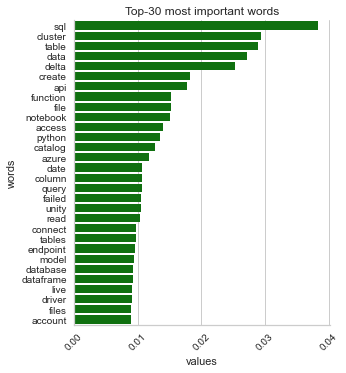

In [234]:
g = sns.catplot(data=word_val_data, color='green',
                 x='values', y='words', kind='bar' )
g.ax.tick_params(axis='x', rotation=45)
g.ax.set_title( f"Top-{N_WORDS} most important words" )

# Clustering with K-means
Selecting number of clusters

In [25]:
cluster_sizes = range(2, 20+1)
kmeans_models = [ KMeans(i, n_init=20, random_state=2140) for i in cluster_sizes ]
cluster_score = []

for kmeans in kmeans_models:
    y = kmeans.fit_predict(data_pca)
    score = silhouette_score(data_pca, y)
    cluster_score.append( ( kmeans.n_clusters, score) )

cluster_score=np.array(cluster_score)

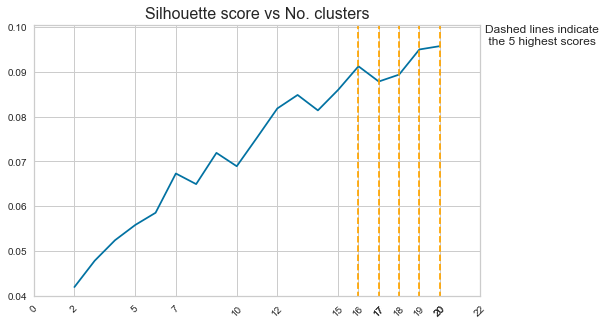

In [26]:
scores = cluster_score[:, 1]
clusters = cluster_score[:, 0]
max_score_clusters = []

fig, ax = plt.subplots( figsize=(8,5) )
ax = sns.lineplot( x=clusters, y=scores, ax=ax )
ax.set_title("Silhouette score vs No. clusters", fontsize=16)

for i in np.argsort( scores )[-5:]:
  ax.vlines(clusters[i], 0, 1, linestyles='--', colors='orange')
  max_score_clusters.append( clusters[i] )

ax.text(1.01, 1, f"Dashed lines indicate\n the {len(max_score_clusters)} highest scores",
        transform=ax.transAxes, ha='left', va='top')

xticks = ax.get_xticks().astype(int)
xticks = np.append(xticks, max_score_clusters)
ax.set_xticks( xticks )
ax.tick_params(axis='x', rotation=45)

ax.set_ylim( [ 0.95*min(scores), 1.05*max(scores) ] )
ax.set_xlim( [ 0, max(clusters)+2 ] )

plt.show()

In [27]:
n_clusters=13
kmeans_model = KMeans(n_clusters =13, n_init=20, random_state=2140)
y = kmeans_model.fit_predict(data_pca)

# Results visualization
Silhouette samples

In [28]:
sample_scores = silhouette_samples( data_pca, y )
sample_scores_df =  pd.DataFrame( data = {'Cluster':y, 'Silhouette':sample_scores} )
sample_scores_df = sample_scores_df.reset_index()
sample_scores_df=sample_scores_df.sort_values('Silhouette', ascending=False)

In [29]:
sample_scores_df

,index,Cluster,Silhouette
4141,4141,9,0.668629
4264,4264,9,0.668629
4196,4196,9,0.668629
4197,4197,9,0.668629
4198,4198,9,0.668629
...,...,...,...
997,997,4,-0.127356
2313,2313,4,-0.143944
5093,5093,4,-0.174935
4077,4077,4,-0.186718


In [30]:
kmeans_pca_scale = KMeans(n_clusters=13, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(data_pca)

In [31]:
# assign predicted clusters
labels = kmeans_pca_scale.labels_
#print(len(labels)) 
# create a dataframe that contains 
# clusters matched to pages and their queries 
mapping = list(zip(labels, grouped_df.index, queries))
clusters = pd.DataFrame(mapping, columns=['cluster','url','search_text'])
clusters.head()
clusters.head(10)

,cluster,url,search_text
0,7,https://community.databricks.com/s/feed/0D53f0...,cluster sizing
1,0,https://community.databricks.com/s/feed/0D53f0...,certificate errors
2,0,https://community.databricks.com/s/feed/0D53f0...,update cloudformation template editing cloudfo...
3,0,https://community.databricks.com/s/feed/0D53f0...,free community edition
4,0,https://community.databricks.com/s/feed/0D53f0...,livre pour apprendre databricks office hours u...
5,0,https://community.databricks.com/s/feed/0D53f0...,task api in databricks
6,1,https://community.databricks.com/s/feed/0D53f0...,tar file create table from csv
7,0,https://community.databricks.com/s/feed/0D53f0...,assignment help
8,0,https://community.databricks.com/s/feed/0D53f0...,add rsa file path
9,0,https://community.databricks.com/s/feed/0D53f0...,identity column identity column foreign key


In [208]:
clusters[clusters.url.str.contains('feed')]

,cluster,url,search_text
0,7,https://community.databricks.com/s/feed/0D53f0...,cluster sizing
1,0,https://community.databricks.com/s/feed/0D53f0...,certificate errors
2,0,https://community.databricks.com/s/feed/0D53f0...,update cloudformation template editing cloudfo...
3,0,https://community.databricks.com/s/feed/0D53f0...,free community edition
4,0,https://community.databricks.com/s/feed/0D53f0...,livre pour apprendre databricks office hours u...
5,0,https://community.databricks.com/s/feed/0D53f0...,task api in databricks
6,1,https://community.databricks.com/s/feed/0D53f0...,tar file create table from csv
7,0,https://community.databricks.com/s/feed/0D53f0...,assignment help
8,0,https://community.databricks.com/s/feed/0D53f0...,add rsa file path
9,0,https://community.databricks.com/s/feed/0D53f0...,identity column identity column foreign key


# BIGRAMS

In [32]:
def find_bigrams(input_list):
    return list(zip(input_list, input_list[1:]))

In [33]:
from nltk import pos_tag, word_tokenize

In [34]:
from collections import Counter
from nltk.tokenize import word_tokenize
 
my_dict1 = {}
n_clusters = clusters['cluster'].unique()
n=3 
# for each cluster
for c in n_clusters: 
    # 1
    asset = clusters[clusters['cluster'] == c] 
    asset = asset['search_text']
    m_asset = ' '.join(asset)
    # 2
    tokens = word_tokenize(m_asset)
    # 3
    words = [word for word in tokens if not word in stops]
    # 4
    bigrams = find_bigrams(words)
    bigrams = list(map(' '.join, bigrams))
    # 5
    counts = Counter(bigrams)
    # 6
    most_common = counts.most_common(4)
    most_freq = [bigram[0] for bigram in most_common]
    # 7
    my_dict1[c] = ','.join(most_freq)
     
my_dict1

{7: 'cluster policy,cluster cluster,policy cluster,cluster policies',
 0: 'feature store,create database,database create,store feature',
 1: 'create table,table create,delta live,live tables',
 8: 'change data,data type,data types,type data',
 2: 'unity catalog,catalog unity,public preview,catalog public',
 9: 'service principal,principal service,service account,service principals',
 3: 'jdbc driver,driver jdbc,cloud fetch,databricks_error_message :',
 11: 'notebook notebook,import notebook,notebook import,notebook run',
 12: 'sql endpoint,endpoint sql,sql sql,sql endpoints',
 4: 'primary key,key primary,managed keys,travel travel',
 5: 'date date,date format,format date,current date',
 6: 'create function,function create,function sql,window function',
 10: 'hive metastore,metastore hive,external metastore,metastore external'}

In [35]:
# Add number of article per cluster
val_count = clusters['cluster'].value_counts()
for i in range(len(val_count)):
    my_dict1[i] += f' ({val_count[i]})'

In [36]:
 my_dict1

{7: 'cluster policy,cluster cluster,policy cluster,cluster policies (219)',
 0: 'feature store,create database,database create,store feature (3636)',
 1: 'create table,table create,delta live,live tables (343)',
 8: 'change data,data type,data types,type data (178)',
 2: 'unity catalog,catalog unity,public preview,catalog public (107)',
 9: 'service principal,principal service,service account,service principals (39)',
 3: 'jdbc driver,driver jdbc,cloud fetch,databricks_error_message : (80)',
 11: 'notebook notebook,import notebook,notebook import,notebook run (100)',
 12: 'sql endpoint,endpoint sql,sql sql,sql endpoints (232)',
 4: 'primary key,key primary,managed keys,travel travel (40)',
 5: 'date date,date format,format date,current date (69)',
 6: 'create function,function create,function sql,window function (89)',
 10: 'hive metastore,metastore hive,external metastore,metastore external (94)'}

# Use the Clustered Data

In [37]:
show_k = 4
 
print('Cluster number: ', show_k)
print('\nTop bigrams: ')
print(my_dict1[show_k])
print('\nTitles in the cluster: ')
pages = clusters['search_text'][clusters['cluster'] == show_k]
for page in pages:
    print(page)

Cluster number:  4

Top bigrams: 
primary key,key primary,managed keys,travel travel (40)

Titles in the cluster: 
mount the adls filesystem using sas key
mount the adls filesystem using sas key adsl mount advantages
surrogate key surrogate keys
create secret keys spark submit key vault "secret scope"
primary key parallel processing surrogate key primary key
primary key constraints primary key constraint
mount the adls filesystem using sas key
scala protobuf udf performance import failed with error: could not deserialize: key not found
surrogate keys surrogate key surrogate keys surrogate key
create sql table sql like incremental primary key
spark submit key vault
jdbc overwrite org.postgresql.util.psqlexception: error: cannot truncate a table referenced in a foreign key constraint
incremental primary key
import failed with error: could not deserialize: key not found
feature importance primary key machine learning feature store primary key feature discovery primary key primary key feat

# Most Important words in each cluster

In [38]:
def most_important_words(data_tfidf, y, topn=10):

    n_clusters = len(np.unique(y))
    result = []
    for i in range(n_clusters):
        ith_cluter_word_sum = np.mean(data_tfidf[np.argwhere(y==i).flatten()], axis=0)

        word_ids = np.array( np.argsort( ith_cluter_word_sum )[0, -topn:] )
        word_ids = word_ids.reshape( -1 )
        result = result + [ (i, id, ith_cluter_word_sum[0, id] ) for id in word_ids ]

    return result

In [39]:
word_cluster_df = pd.DataFrame( most_important_words( data_tfidf, y, topn=5 ), columns=["Cluster", "WordId", "Score"] )
word_cluster_df["Word"] = word_cluster_df["WordId"].apply( lambda id: tfidf_vec.get_feature_names()[id] )
word_cluster_df = word_cluster_df.sort_values( "Score", ascending=False )
word_cluster_df.head()

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Cluster,WordId,Score,Word
44,8,85,0.679477,date
4,0,260,0.672682,query
29,5,16,0.632697,api
54,10,222,0.619891,notebook
9,1,79,0.589819,data


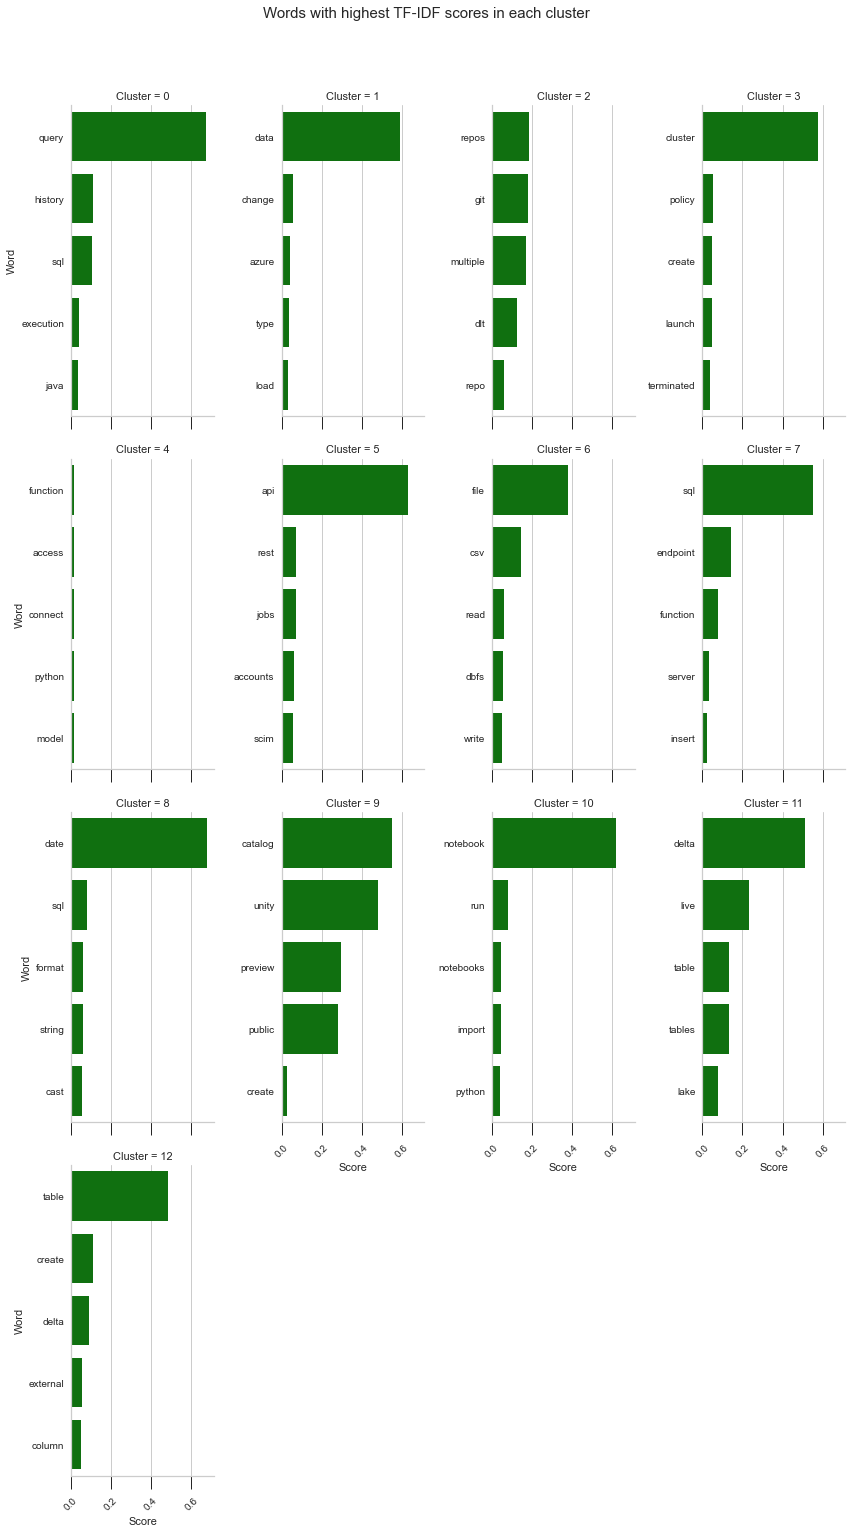

In [40]:
g = sns.catplot(x="Score", y="Word", col="Cluster", data=word_cluster_df, 
                sharey=False, col_wrap=4, kind="bar",
                color = 'green', aspect=.6)
[ ax.tick_params(axis='x', rotation=45, size=13) for ax in g.axes.flatten() ]
g.fig.suptitle( "Words with highest TF-IDF scores in each cluster", y = 1.05, fontsize=15 )
plt.show()

# 2D view of clusters and data with U-Map

In [41]:
!pip install umap-learn

In [42]:
import umap
output_notebook()

Loading BokehJS ...

In [43]:
umap_red = umap.UMAP(n_neighbors=12, metric='correlation', 
                     random_state=214)
data_2d = umap_red.fit_transform( data_pca )

In [44]:
data_2d_df = pd.DataFrame( data={"x":data_2d[:, 0], 
                                 "y":data_2d[:, 1], 
                                 "Cluster":y,
                                 "Silhouette":sample_scores } )


c_pallete = list(Category20[13])
c_pallete[7], c_pallete[0] = c_pallete[0], c_pallete[7]

data_2d_df['colors'] = [ c_pallete[i] for i in data_2d_df['Cluster']]
data_2d_df['search_text'] = df['search_text']
# #Limiting the text's size
data_2d_df['search_text'] = data_2d_df['search_text'].apply( lambda s: s[:100]+'...' if len(s)>100 else s )

data_2d_df, _,_,_ = train_test_split(data_2d_df, data_2d_df, train_size=4500, stratify=data_2d_df['Cluster'])

data_2d_cdf = ColumnDataSource(data_2d_df)


In [45]:
fig = figure(
    title='UMAP 2D projection of the points and clusters',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset', 'save')
)

fig.add_tools(HoverTool(tooltips="""
                                      <div>
                                        <span style='font-size: 10px; color: @colors'>@ementa</span>
                                        <span style='font-size: 10px'>cluster - </span>
                                        <span style='font-size: 10px'>@Cluster ;</span>
                                        <span style='font-size: 10px'>index - </span>
                                        <span style='font-size: 10px'>$index ;</span>
                                        <span style='font-size: 10px'>silhouette: </span>
                                        <span style='font-size: 10px'>@Silhouette</span>
                                      </div>
                                 """)
              )

fig.circle('x','y', source=data_2d_cdf, color='colors', 
           legend_group="Cluster",
           line_alpha=0.6, fill_alpha=0.6, size=2)

show(fig)
save(fig, "UMAP2D.html")

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/bokeh/io/saving.py:142: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/bokeh/io/saving.py:154: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/Users/ankush.singal/Databricks_issues_CS_clustering /UMAP2D.html'

# Saving Models

In [46]:
pickle.dump(tfidf_vec, open('tfidf_vec.pickle', 'wb'))

In [47]:
pickle.dump(pca, open('pca.pickle', 'wb'))

In [48]:
pickle.dump(kmeans_model, open('kmeans_model.pickle', 'wb'))

# convert urls to pdfs

In [235]:
clusters.url[4]

'https://community.databricks.com/s/feed/0D53f00001PozGOCAZ'

In [156]:
clusters.head()

,cluster,url,search_text
0,7,https://community.databricks.com/s/feed/0D53f0...,cluster sizing
1,0,https://community.databricks.com/s/feed/0D53f0...,certificate errors
2,0,https://community.databricks.com/s/feed/0D53f0...,update cloudformation template editing cloudfo...
3,0,https://community.databricks.com/s/feed/0D53f0...,free community edition
4,0,https://community.databricks.com/s/feed/0D53f0...,livre pour apprendre databricks office hours u...


In [160]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(data_pca)

In [182]:
def getind(c):
     return clusters[clusters.search_text == c].index.tolist()

In [183]:
def getscene(i):
     return clusters[clusters.index == i].search_text.tolist()

In [184]:
similar = list(enumerate(cosine_sim[i]))
similar[:5]

[(0, -0.02644118546198027),
 (1, 0.0014646948106776987),
 (2, -0.002819989045543694),
 (3, -0.0037271200706162325),
 (4, 0.040054355832641546)]

In [185]:
#https://medium.com/@nisha.imagines/nlp-with-python-text-clustering-based-on-content-similarity-cae4ecffba3c

In [186]:
similar_list=[]
disimilar_list=[]
for m in similar:
    t = getscene(m[0])
    if m[1] > 0.15:
        similar_list.append(t)
    else:
        disimilar_list.append(t)

In [194]:
pd.DataFrame(similar_list, columns = ['similar_list'])

,similar_list
0,identity column identity column foreign key
1,identity column low shuffle merge
2,delta table case sensitive column names
3,partitioning by generated column
4,xml column
...,...
105,"expected: booleantype, found: binary send emai..."
106,is not empty but it's not delta table update ...
107,list column names notebook path delete user fo...
108,show column names find columns in a table
